__Initialization__

Assumes Python 3

---------------- Only run once on the machine to get things configured -------------------


In [ ]:
!echo 'This could take awhile. Status at bottom will show idle when done.'
!git clone https://github.com/JustAnotherArchivist/snscrape
!echo done

In [ ]:
!echo 'This could take awhile. Status at bottom will show idle when done.'
!pip install snscrape
!pip install pandas
!pip install seaborn
!echo done

---------------------------- Below here can be run multiple times --------------------------------

__Parse tweets into a Pandas data set__

Have to run this before trying to prepare the dataset for plotting or plotting.

Parameters

* Set workingDataMaxRows to None (workingDataMaxRows = None) to show all rows or use a number, like 10, to limit ouput (workingDataMaxRows = 10)
* Set maxResults to None if you want all tweets or limit by setting a number
* Set since to None for all dates or use YYYY-MM-DD format to get all tweets since that date
* Set showWorkingData to True to show data grids with sample data at each step
* Set filePrefix to something descriptive so you know which files to download

Running: snscrape --max-results 100 --jsonl --since 2020-01-01 twitter-user atrupar
This can take awhile. The status bar at the bottom of the screen will say Busy until this is done.
Done scraping Twitter
File created


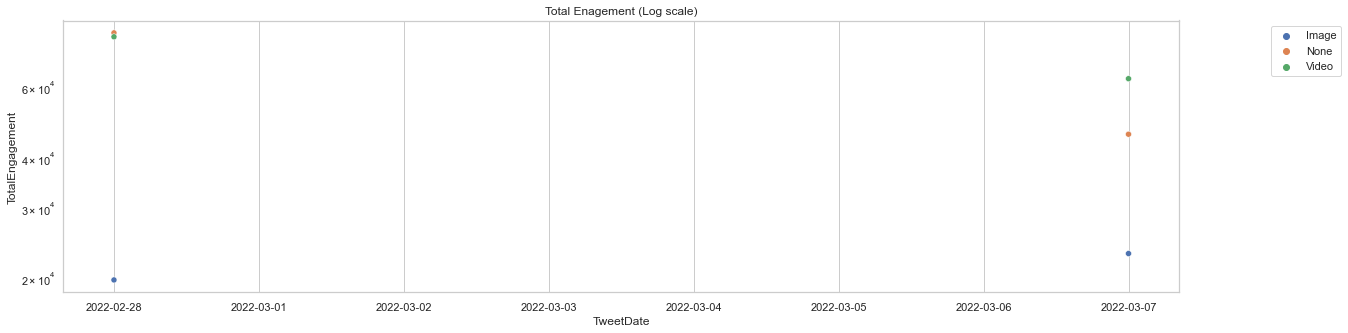

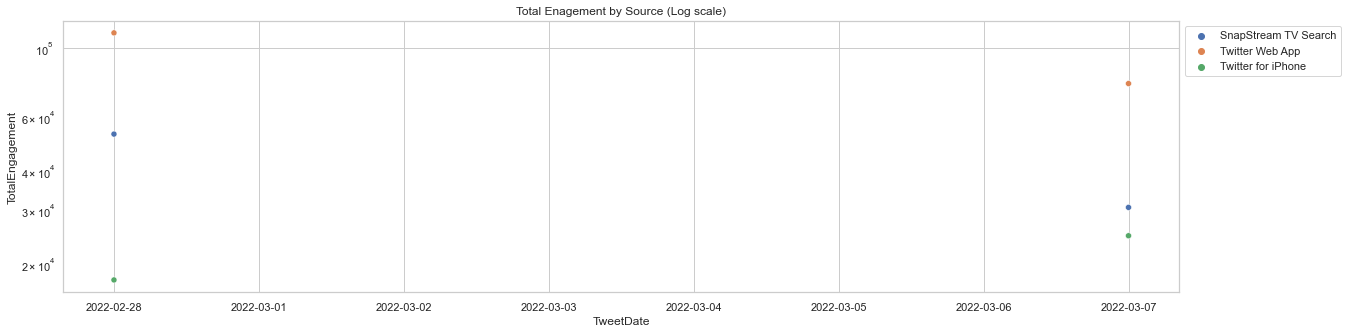

In [ ]:
import json
import pandas
import seaborn
import os
import glob
import matplotlib.pyplot as plt

# Parameters
workingDataMaxRows = 10
maxResults = 100
since = '2020-01-01'
twitterUser = 'atrupar'
filePrefix = 'atrupar'
showWorkingData = False

#functions

def scrape_twitter():
    if maxResults is None:
        maxResultsParam = ''
    else:
        maxResultsParam = f'--max-results {maxResults}'
    
    if since is None:
        sinceParam = ''
    else:
        sinceParam = f'--since {since}'

    print(f'Running: snscrape {maxResultsParam} --jsonl {sinceParam} twitter-user {twitterUser}')
    print('This can take awhile. The status bar at the bottom of the screen will say Busy until this is done.')

    results  = !snscrape {maxResultsParam} --jsonl {sinceParam} twitter-user {twitterUser}

    print('Done scraping Twitter')
    
    return results

def build_data_frame(results):
    temp = []
    
    for json_str in results:
        result = json.loads(json_str)
    
        isVideo = False
        isImage = False
        mediaType = 'None'
        views = 0
        media = result['media']
        if (media is None) == False and len(media) > 0:
            if media[0]['_type'] == 'snscrape.modules.twitter.Photo':
                isImage = True
                mediaType = 'Image'
            elif media[0]['_type'] == 'snscrape.modules.twitter.Video':
                isVideo = True
                mediaType = 'Video'
                views = media[0]['views']

        totalEngagement =  result['replyCount'] + result['retweetCount'] + result['likeCount'] + result['quoteCount']
        totalEnagementWithVideoViews = totalEngagement + views

        record = {
            'TweetId': result['id'],
            'TweetDate': result['date'],
            'Replies': result['replyCount'],
            'Retweets': result['retweetCount'],
            'Likes': result['likeCount'],
            'Quotes': result['quoteCount'],
            'Source': result['sourceLabel'],
            'IsVideo': isVideo,
            'IsImage': isImage,
            'VideoViews': views,
            'MediaType': mediaType,
            'TotalEngagement':totalEngagement,
            'TotalEngagementWithVideoViews':totalEnagementWithVideoViews
        }

        temp.append(record)

    output = pandas.DataFrame(temp)

    # Put TweetDate into proper date format
    output['TweetDate'] = pandas.to_datetime(output['TweetDate'])

    if showWorkingData:
        with pandas.option_context('display.max_rows', workingDataMaxRows,):
            display(output)
            
    return output

def output_raw(df):
    df.to_csv(f'{filePrefix}_RawData.csv')
    print('File created')

def create_scatter_plots(df):
    seaborn.set(style='whitegrid')

    outputGroupedByMediaType = df.groupby(['MediaType', pandas.Grouper(key='TweetDate', freq='W-MON')]).agg({'TotalEngagement':'sum','TotalEngagementWithVideoViews':'sum'}).reset_index().sort_values('TweetDate')
    if showWorkingData:
        with pandas.option_context('display.max_rows', workingDataMaxRows,):
            display(outputGroupedByMediaType)

    plt.figure(figsize=(20, 5))
    scatter2 = seaborn.scatterplot(x='TweetDate', y='TotalEngagement', hue = 'MediaType', data=outputGroupedByMediaType).set(title='Total Enagement (Log scale)', yscale='log')
    lgd = plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.savefig(f'{filePrefix}_TotalEnagementByMediaTypeLogScale.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

    outputGroupedBySource = df.groupby(['Source', pandas.Grouper(key='TweetDate', freq='W-MON')]).agg({'TotalEngagement':'sum','TotalEngagementWithVideoViews':'sum'}).reset_index().sort_values('TweetDate')
    if showWorkingData:
        with pandas.option_context('display.max_rows', workingDataMaxRows,):
            display(outputGroupedBySource)

    plt.figure(figsize=(20, 5))
    scatter3 = seaborn.scatterplot(x='TweetDate', y='TotalEngagement', hue = 'Source', data=outputGroupedBySource).set(title='Total Enagement by Source (Log scale)', yscale='log')
    lgd = plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.savefig(f'{filePrefix}_TotalEnagementBySourceLogScale.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(20, 5))
    scatter4 = seaborn.scatterplot(x='TweetDate', y='TotalEngagementWithVideoViews', hue = 'Source', data=outputGroupedBySource).set(title='Total Enagement by Source with Video Views (Log scale)', yscale='log')
    lgd = plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.savefig(f'{filePrefix}_TotalEnagementBySourceIncludingVideoViewsLogScale.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    
    print(f"Files starting with '{filePrefix}_' are the ones that contain your CSV data and charts")
    
def clean_output_files():
    for filename in glob.glob(f"{filePrefix}_*"):
        os.remove(filename) 
    
#main
clean_output_files()
results = scrape_twitter()
df = build_data_frame(results)
output_raw(df)
create_scatter_plots(df)
